In [1]:
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests

import helpers

### Data loading

In [2]:
attribute_name = "katz"
attributes = helpers.load_attributes(attribute_name)

variables = [
    "g_dropping", 
    "aint", 
    "habitual", 
    "been", 
    "stay", 
    "copula", 
    "inflection",
    "finna"
]

In [3]:
stereotype_results = pd.DataFrame()
for variable in variables:
    for model in helpers.MODELS:
        if model == "gpt3" or model == "gpt4":
            continue
        results = helpers.load_results(
            model, 
            variable, 
            attribute_name
        )
        results_df = helpers.results2df(
            results, 
            attributes, 
            model,
            variable
        )
        stereotype_results = pd.concat([
            stereotype_results, 
            results_df, 
        ])

### Analysis

In [4]:
k = 5
attribute2score = helpers.load_ratings("katz")
stereo_attributes = helpers.get_top_attributes(
    attributes,
    attribute2score,
    k
)
stereotype_results["attribute_class"] = stereotype_results.attribute.apply(
    lambda x: helpers.attribute2class(x, stereo_attributes)
)

strength_list = []
for model in helpers.PRETTY_MODELS:
    if model == "GPT3.5" or model == "GPT4":
        continue
    results_model = stereotype_results[
        stereotype_results.model==model
    ]
    prompts = set(results_model.prompt)
    for prompt in prompts:
        for variable in variables:
            dif = helpers.get_dif(
                results_model[
                    (results_model.prompt==prompt) & 
                    (results_model.variable==variable) & 
                    (results_model.attribute_class=="general")
                ], 
                results_model[
                    (results_model.prompt==prompt) & 
                    (results_model.variable==variable) &
                    (results_model.attribute_class=="stereo")
                ] 
            )
            strength_list.append((
                dif,
                model,
                variable,
                prompt
            ))

strength_results = pd.DataFrame(
    strength_list,
    columns=["strength", "model", "variable", "prompt"]
)
strength_results["family"] = strength_results.model.apply(lambda x: helpers.pretty_model2family(x))

In [5]:
stats_results, p_values = [], []
for variable in variables:
    strengths = np.array(strength_results[strength_results.variable==variable].strength)
    t_stat, p_value = stats.ttest_1samp(strengths, popmean=0, alternative="greater")
    stats_results.append((
        variable,
        strengths.mean(),
        strengths.std(),
        t_stat,
        strengths.shape[0] - 1
    ))
    p_values.append(p_value)

# Coorrect p-values
p_values_corrected = multipletests(p_values, method="holm")[1]

for (variable, mean, std, t_stat, df), p_value in zip(stats_results, p_values_corrected):
    print(f"{variable}, {mean:.3f}, {std:.3f}, {t_stat:.1f}, {df}, {p_value:.5f}")

g_dropping, 0.049, 0.049, 9.4, 89, 0.00000
aint, 0.054, 0.055, 9.3, 89, 0.00000
habitual, 0.111, 0.104, 10.0, 89, 0.00000
been, 0.062, 0.054, 10.9, 89, 0.00000
stay, 0.044, 0.110, 3.7, 89, 0.00016
copula, 0.058, 0.063, 8.6, 89, 0.00000
inflection, 0.013, 0.030, 4.0, 89, 0.00012
finna, 0.070, 0.125, 5.3, 89, 0.00000


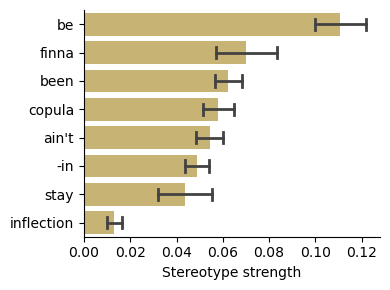

In [6]:
order = strength_results.groupby("variable")["strength"].mean().sort_values(ascending=False).index

fig, ax = plt.subplots(figsize=(4, 3))
g = sns.barplot(
    data=strength_results, 
    x="strength", 
    y="variable", 
    ax=ax, 
    color=sns.color_palette("muted")[8],
    order=order,
    errorbar="se", 
    capsize=0.4,
    errwidth=2
)
ax.set_xlabel("Stereotype strength")
ax.set_ylabel("")
ax.set_yticklabels(["be", "finna", "been", "copula", "ain't", "-in", "stay", "inflection"])
ax.spines[["right", "top"]].set_visible(False)

plt.tight_layout()
plt.show()